In [1]:
import numpy as np
import networkx as nx
from helpers.test_generators import *
from helpers.test_generator_helpers import *
import networkx as nx
from helpers.plots import *
import networkx as nx
from matplotlib import pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score as ri
from sklearn.metrics import accuracy_score
import scipy
import pickle
import pandas as pd
import seaborn as sns
import ot
import warnings
import fgot_mgd
import scipy.linalg as slg
import fgot_stochastic_mgd
from sklearn.cluster import SpectralClustering
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.strategies import get_strategy
from utils.help_functions import remove_edges

In [3]:
def ShowPermutation(P, P_true, title_s):
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(P)
    plt.title("Estimated" + title_s)

    plt.subplot(1,3,2)
    plt.imshow(P_true)
    plt.title("True" + title_s)

    plt.subplot(1,3,3)
    plt.imshow(P_true-P)
    plt.title("Differences" + title_s)

    plt.show()

In [4]:
def plot_graphs(x, y, P, alpha=0.1, ones=False):

    plt.figure(figsize=(15,10))

    plt.subplot(2,3,1)
    plt.imshow(x)
    plt.title("x")

    plt.subplot(2,3,2)
    plt.imshow( P @ y @ P.T)
    plt.title("P @ y @ P.T")

    plt.subplot(2,3,3)
    plt.imshow(np.abs(x -  P @ y @ P.T))
    plt.title("Absolute errors in L1")

    plt.subplot(2,3,4)
    plt.imshow(regularise_invert_one(x, alpha, ones))
    plt.title("lg.inv(x)")

    plt.subplot(2,3,5)
    plt.imshow( regularise_invert_one(P@ y @P.T, alpha, ones))
    plt.title("lg.inv(P @ y @ P.T)")

    plt.subplot(2,3,6)
    plt.imshow(np.abs( regularise_invert_one(x, alpha, ones) - regularise_invert_one(P@ y @P.T, alpha, ones)))
    plt.colorbar()
    plt.title("Absolute errors in inverted L1")

    plt.show()

## Create test data

In [5]:
m = 20
pns = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
pns = [0.75, 0.5, 0.25, 0]
rep = 10


def create_tests_random_original(rep, m, pns, testgen):
    g2list = [[get_laplacian(testgen(int((1-p)*m))) for p in pns] for i in range(rep)]
    Ptrue_list = [[permutation_generator(int((1-p)*m)) for p in pns] for i in range(rep)]
    
    g1list = [[P_true @ get_laplacian(testgen(int((1-p)*m))) @ P_true.T for (P_true, p) in zip(Ptrus, pns)] for (Ptrus, i) in zip(Ptrue_list,range(rep))] 
    return g1list, g2list, Ptrue_list

def create_tests_random(rep, m, pns, testgen):
    g2list = []
    Ptrue_list = []
    g1list = []
    for i in range(rep):
        g2list_inner = []
        Ptrue_list_inner = []
        g1list_inner = []
        for j, p in enumerate(pns):
            l2 = get_laplacian(testgen(int((1-p)*m)))
            P_true = permutation_generator(int((1-p)*m))
            l1 = P_true @ get_laplacian(testgen(int((1-p)*m))) @ P_true.T
            
            g2list_inner.append(l2)
            Ptrue_list_inner.append(P_true)
            g1list_inner.append(l1)
        
        g2list.append(g2list_inner)
        Ptrue_list.append(Ptrue_list_inner)
        g1list.append(g1list_inner)
    
    return g1list, g2list, Ptrue_list

dsdp_g1list, dsdp_g2list, Ptrue_list = create_tests_random(rep, m, pns, 
                                       lambda m: sbm_generator(m, pin=0.7, pout=0.2, ncomm=4))

# shape : (rep, pns)
# Why P_true?

In [6]:
from joblib import Parallel, delayed
import time
def get_align_matrices(g1list, g2list, imputer):
    def inner(l1, l2, it):
        print('\rIteration', it+1, 'of', len(g1list), end='')
        start = time.time()
        res = imputer(l1, l2)
        end = time.time()
        return res, end - start

    indices = [(g1,g2, it) for it, (g1subl, g2subl) in enumerate(zip(g1list, g2list)) for g1, g2 in zip(g1subl, g2subl)]
    
    dist_array = Parallel(n_jobs=1)(delayed(inner)(g1, g2, it) for (g1,g2, it) in indices)
    count = 0
    D = list()
    for i, (g1subl, g2subl) in enumerate(zip(g1list, g2list)):
        temp = list()
        for j, (g1, g2) in enumerate(zip(g1subl, g2subl)):
            temp.append(dist_array[count])
            count = count + 1
        D.append(temp)
    return D

In [7]:
def create_distance_matrix(L):
    g = nx.from_numpy_matrix(np.diag(np.diag(L)) - L)
    C = nx.floyd_warshall_numpy(g)
    return C

def find_gw_distances(C1, C2, epsilon = 2e-2):
    p = ot.unif(len(C1))
    q = ot.unif(len(C2))
    gw, log = ot.gromov.entropic_gromov_wasserstein(
    C1, C2, p, q, 'square_loss', epsilon=epsilon, log=True, verbose=False)
    return gw

def get_filters(L1, method, tau = 0.2):
    if method == 'got':
        g1 = np.real(slg.sqrtm(fgot_mgd.regularise_invert_one(L1,alpha = 0.1, ones = False )))
    elif method == 'weight':
        g1 = np.diag(np.diag(L1)) - L1
    elif method == 'heat':
        g1 = slg.expm(-tau*L1)
    elif method == 'sqrtL':
        g1 = np.real(slg.sqrtm(L1))
    elif method == 'L':
        g1 = L1
    elif method == 'sq':
        g1 = L1 @ L1
    return g1
    
def find_trace_sink_wass_filters(L1, L2, epsilon = 7e-4, method = 'got', tau = 0.2):
    n = len(L1)
    m = len(L2)
    p = np.repeat(1/n, n)
    q = np.repeat(1/m, m)
    norm1 = n/10
    norm2 = m/10
    max_iter = 500
    g1= get_filters(L1, method, tau)
    g2= get_filters(L2, method, tau)
    gw, log = fgot_mgd.fgot(g1*norm1, g2*norm2, p, q, epsilon, max_iter=max_iter, tol=1e-9, verbose=False, log=True, lapl = True)

    return gw

def find_trace_sink_wass_filters_reg(L1, L2, epsilon = 7e-4, method = 'got', tau = 0.2):
    n = len(L1)
    m = len(L2)
    p = np.repeat(1/n, n)
    q = np.repeat(1/m, m)
    max_iter = 500
    g1= get_filters(L1, method, tau)
    g2= get_filters(L2, method, tau)

    gw, log = fgot_mgd.fgot(g1, g2, p, q, epsilon*np.max(g1)*np.max(g2)/n, max_iter=max_iter, tol=1e-9, verbose=False, log=True, lapl = True)

    return gw

In [8]:
All_Ps = []
All_names = []

In [9]:
strategy = get_strategy('GOT', it=10, tau=5, n_samples=20, epochs=1500, lr=0.2, seed=42, alpha=0.1)

Pgot_test = get_align_matrices(dsdp_g1list, dsdp_g2list, strategy)

All_Ps.append(Pgot_test)
All_names.append('GOT-test')

Iteration 10 of 10

In [ ]:
strategy = get_strategy('L2', it=10, tau=5, n_samples=20, epochs=1500, lr=0.2, seed=42, alpha=0.1)

Pgot_l2 = get_align_matrices(dsdp_g1list, dsdp_g2list, strategy)

All_Ps.append(Pgot_l2)
All_names.append('GOT-l2')

In [ ]:
P_nv2 = get_align_matrices(dsdp_g1list, dsdp_g2list,
                   lambda L1, L2: fgot_stochastic_mgd.fgot_stochastic(get_filters(L2, 'sq'), get_filters(L1, 'sq'), tau=1, n_samples=5, epochs=1000, lr=50*len(L1)*len(L2), std_init = 5, loss_type = 'w_simple', tol = 1e-12, adapt_lr = True)
                            )
All_Ps.append(P_nv2)
All_names.append('$g(L) = L^2$ stochastic')

In [10]:
Pgot = get_align_matrices(dsdp_g1list, dsdp_g2list,
                       lambda L1, L2: find_trace_sink_wass_filters_reg(L1, L2, 0.006, 'got')
                       )
All_Ps.append(Pgot)
All_names.append('$g(L) = L^{\dagger/2}$')

Iteration 10 of 10

In [ ]:
PstoH = get_align_matrices(dsdp_g1list, dsdp_g2list,
                   lambda L1, L2: fgot_stochastic_mgd.fgot_stochastic(get_filters(L2, 'got'), get_filters(L1, 'got'), tau=1, n_samples=5, epochs=1000, lr=50*len(L1)*len(L2), std_init = 5, loss_type = 'w_simple', tol = 1e-12, adapt_lr = True)
                            )
All_Ps.append(PstoH)
All_names.append('$g(L) = L^{\dagger/2}$ stochastic')

In [ ]:
Pgw = get_align_matrices(dsdp_g1list, dsdp_g2list,
                       lambda L1, L2: find_gw_distances(create_distance_matrix(L1), create_distance_matrix(L2), 2e-2)
                                  )
All_Ps.append(Pgw)
All_names.append('GW')

In [ ]:
PLsq = get_align_matrices(dsdp_g1list, dsdp_g2list,
                       lambda L1, L2: find_trace_sink_wass_filters_reg(L1, L2, 0.003, 'sq')
                       )
All_Ps.append(PLsq)
All_names.append('$g(L) = L^2$')

In [ ]:
strategy = get_strategy('random', it=10, tau=5, n_samples=20, epochs=1500, lr=0.2)    

Prand = get_align_matrices(dsdp_g1list, dsdp_g2list, strategy)
All_Ps.append(Prand)
All_names.append('random')

In [11]:
import got_nips as got_nips
Pgot_nips = get_align_matrices(dsdp_g1list, dsdp_g2list,
                       lambda L1, L2: got_nips.find_permutation(L1, L2, it=10, tau=5, n_samples=20, epochs=1500, lr=0.2, 
                                   loss_type = 'w', alpha = 0.1, ones = True)
                       )

# Pgot_nips2 = get_align_matrices(dsdp_g1list, dsdp_g2list,
#                        lambda L1, L2: got_nips.find_permutation(L1, L2, it=10, tau=5, n_samples=5, epochs=150, lr=0.2, 
#                                    loss_type = 'w', alpha = 0.1, ones = True)
#                        )
All_Ps.append(Pgot_nips)
All_names.append('GOT')

Iteration 10 of 10

In [ ]:
# All_Ps = [Pgw, PstoH, Pgot, P_nv2, PLsq, Pgot_nips2]
# All_names = ['GW', '$g(L) = L^{\dagger/2}$ stochastic', '$g(L) = L^{\dagger/2}$',  '$g(L) = L^2$ stochastic','$g(L) = L^2$', 'GOT']

# All_Ps = [Pgw, PstoH, Pgot, P_nv2, PLsq]
# All_names = ['GW', '$g(L) = L^{\dagger/2}$ stochastic', '$g(L) = L^{\dagger/2}$',  '$g(L) = L^2$ stochastic','$g(L) = L^2$']

# All_Ps = [Pgot_nips2, Pgw]
# All_names = ['GOT', 'GW']

In [ ]:
# strategy = get_strategy('GW', it=10, tau=5, n_samples=20, epochs=1500, lr=0.2)

# Pgw_test = get_align_matrices(dsdp_g1list, dsdp_g2list, strategy)
# All_Ps.append(Pgw_test)
# All_names.append('gw-test')

3


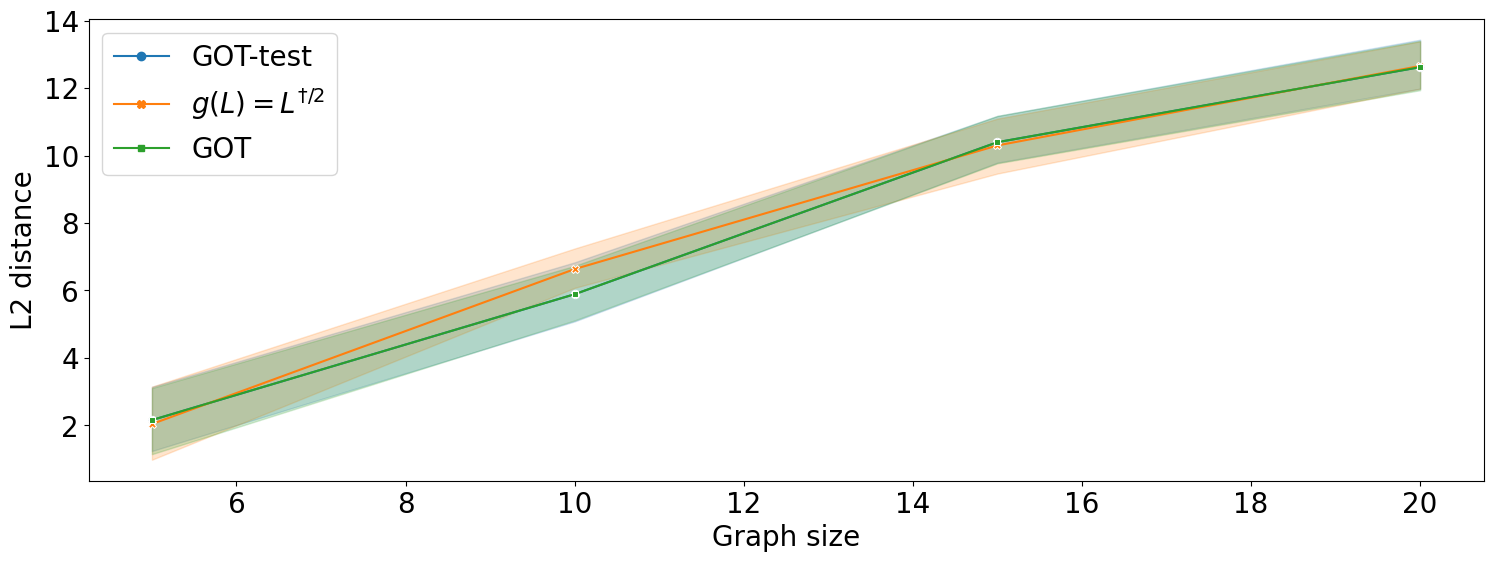

<Figure size 1800x600 with 0 Axes>

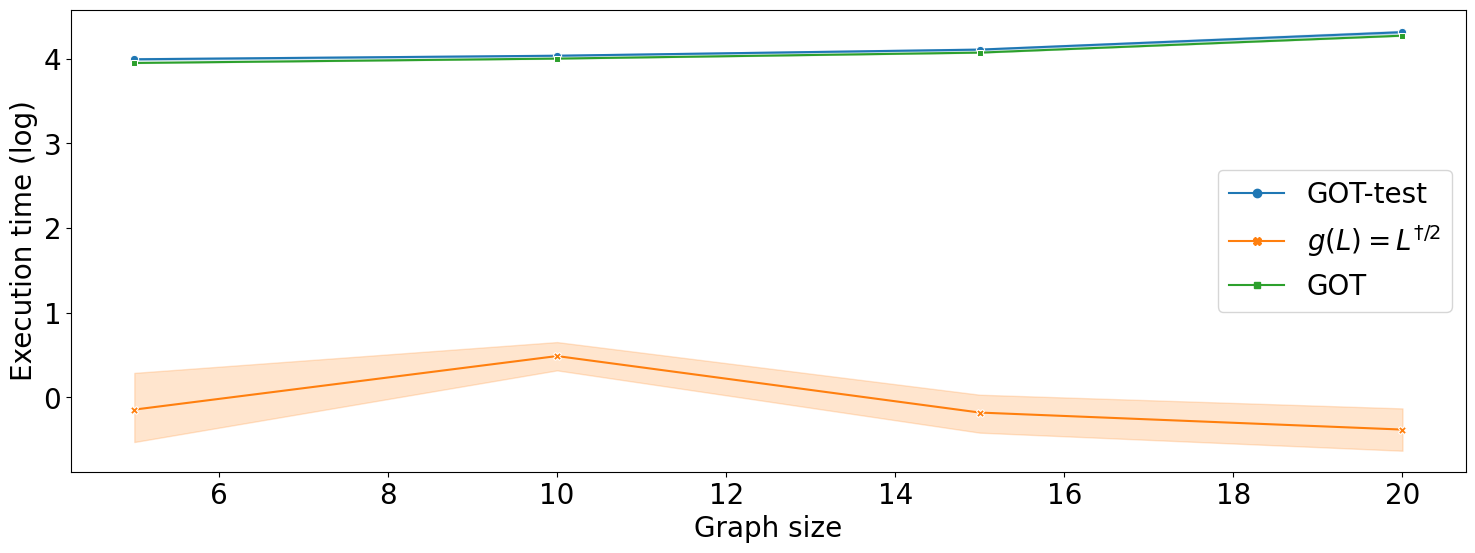

<Figure size 1800x600 with 0 Axes>

In [12]:
def get_loss_sc(g2list, g1list, Plist, name, Ptruelist):
    def inner(L, l_true, P_true, P, name):
        """Compute the loss of the given permutation.
        
        Parameters
        ----------
        L : np.ndarray of shape (n, n)
            Laplacian matrix of the second graph.
        l_true : np.ndarray of shape (n, n)
            Laplacian matix of the first graph.
        P_true : np.ndarray of shape (n, n)
            Not used.
        P : tuple (np.ndarray of shape (n, n), float)
            The permutation matrix for which the loss is calculated, and the computing time.
        name : str
            Name of the alignment strategy.
        
        Returns
        -------
        l2_score : float
            Frobenius norm of P @ L @ P.T - l_true.
        log_time : float
            The log of the computing time.
        """
        P_time = P[1]
        if name[:3] == 'GOT':
            if name == 'GOT':
                P = P[0][2]
            else:
                P = P[0]
            P = P.T
        elif name in ['random', 'gw-test']:
            P = P[0]
        else:
            P = len(l_true) * P[0]
        if name[-3:] == 'ect' or name[-3:] == 'tic':
            P = P.T
#         if name == 'GOT-l2':
#             print(P)
        l1 = l_true
        a1 = np.diag(np.diag(l1)) - l1
        a1[a1<0] = 0
        l2 = P @ L @ P.T
        a2 = np.diag(np.diag(l2)) - l2
        a2[a2<0] = 0

        l2_score = lg.norm(l2 - l1, 'fro')
        return  l2_score, np.log(P_time)
    
    return [[(inner(L, l_true, P_true,P, name)) for (L, l_true, P, P_true) in zip (g2s, g1s, Psubl, Ptsubls)] 
            for (g2s, g1s, Psubl, Ptsubls) in zip(g2list, g1list, Plist, Ptruelist)]


def result_plot(x, res, imp_names, xlabel='', palette=None):
    def to_pandas(x, y, val):
        nrow,_ = y.shape
        out = pd.DataFrame({'y': y.T.flatten(), 'x': np.repeat(x, nrow), 'Loss': val})
        return out
    labels = [ 'L2 distance', 'Execution time (log)']
    for i in range(len(labels)):
        df = pd.concat([to_pandas(x, np.array([[l[i] for l in s] for s in y]), name) for y, name in zip(res, imp_names)])
        s = pd.Series(range(1, df.shape[0] + 1))
        df.set_index(s, inplace=True)
        plt.figure(figsize=(18,6))
        sns.lineplot(x='x', y='y', hue='Loss', markers=True, dashes=False, style = 'Loss', data=df)
        plt.ylabel(labels[i], fontsize=20)
        plt.xlabel(xlabel, fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.legend(prop={"size":20})
        plt.show()
        plt.figure(figsize=(18,6))

ns = [int((1-p)*m) for p in pns]

losses = [get_loss_sc(dsdp_g2list, dsdp_g1list, x,name, Ptrue_list) for (x, name) in zip(All_Ps, All_names)]
print(len(losses))
result_plot(ns, losses, All_names, 'Graph size')
plt.show()

In [ ]:
del All_Ps[-2]
del All_names[-2]